## 引入相关的包

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import os
import pickle
import re
from tensorflow.python.ops import math_ops

## 数据的处理

### 评分数据
分别有用户ID、电影ID、评分和时间戳等字段，数据中的格式：UserID::MovieID::Rating::Timestamp

In [2]:
rating_title = ['UserId' , 'MovieID' , 'Rating' , 'timestamps']
ratings = pd.read_table('../data/ratings.dat' , sep='::' , header=None , names=rating_title , engine='python')
ratings.head()

,UserId,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 用户数据
分别有用户ID、性别、年龄、职业ID和邮编等字段。 数据中的格式：UserID::Gender::Age::Occupation::Zip-code

In [3]:
users_title = ['UserID' , 'Gender' , 'Age' , 'OccupationID' , 'Zip-code']
users = pd.read_table('../data/users.dat' , sep = '::' , header=None , names=users_title , engine='python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### 电影数据
分别有电影ID、电影名和电影风格等字段。数据中的格式：MovieID::Title::Genres

In [4]:
movie_title = ['MovieID' , 'Title' , 'Genres']
movies = pd.read_table('../data/movies.dat' , sep='::' , header=None , names=movie_title , engine='python')
movies.head(30)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### 数据处理的部分

UserID、Occupation和MovieID不用变。

Gender字段：需要将'F'和'M'转换成0和1。

Age字段：要转成7个连续数字0~6,初始数据就是表示范围的。

Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段
转成数字列表，因为有些电影是多个Genres的组合。

Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。

Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

In [5]:
# 读取数据，并且对数据进行预处理
def load_data():
    # 读取用户数据
    users_title = ['UserID' , 'Gender' , 'Age' , 'JobID' , 'Zip-code']
    users = pd.read_table("../data/users.dat",sep = '::',header=None,names=users_title,engine='python')
    users = users.filter(regex = 'UserID|Gender|Age|JobID')  # 按照列进行过滤，只保留这 4 列
    users_origin = users.values  # 把 users的值保存这个副本
    
    # 对用户性别进行处理
    gender_map = {'F':0 , 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)  # 对每个元素进行 map映射
    
    # 对用户年龄进行处理
    age_map = {val:i for i,val in enumerate(set(users['Age']))} # 之所以用 set是因为去除重复
    users['Age'] = users['Age'].map(age_map)   # Age的value 部分是 0-6
    
    # 读取电影数据
    movie_title = ['MovieID' , 'Title' , 'Genres']
    movies = pd.read_table('../data/movies.dat',sep='::',header=None,names=movie_title,engine='python')
    movies_origin = movies.values  # 把 movies的值保存这个副本
    
    # 把 Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    title_map = {val:pattern.match(val).group(1) for i,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)
    
    # 电影类型转为数字的set
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val) # 修改当前集合，把val包含的元素全部加入到 genres_set中且去除重复
    
    # 长度统一，空白部分用 '<PAD>'填充
    genres_set.add('<PAD>')
    # 将电影类型的 set改为 map  value部分是电影类型所对应的 int
    genres2int = {val:i for i , val in enumerate(genres_set)}
    
    #将电影类型转成等长数字列表，长度是
    # 下面得到的是一个 map, key 是 电影类型（可以组合），value是个List，表示电影类型的 数字组合
    genres_map = {val:[genres2int[row] for row in val.split('|')] for i,val in enumerate(set(movies['Genres']))}

    
    #将电影类型转成等长数字列表，长度是18，因为一共18种电影
    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)
    
    # # 生成一个set，里面包含了每个Title中每个词
    title_set = set()
    for val in movies['Title'].str.split():   # 没有参数，按照空格换行符制表符等分割
        title_set.update(val)
    title_set.add('<PAD>')
    
    # 然后把每个词转化为 int类型
    title2int = {val:i for i , val in enumerate(title_set)}
    
    #将电影 Title转为等长的数字列表，长度为15 
    title_count = 15
    # key是电影Title，value 是电影Title分割出来的词的int 表示
    title_map = {val:[title2int[row] for row in val.split()] for i,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    # 这样就把原先 movies['Title']改为了 List[int]表示
    movies['Title'] = movies['Title'].map(title_map) 
    
    
    # 读取评分数据集
    ratings_title = ['UserID' , 'MovieID' , 'ratings' , 'timestamps']
    ratings = pd.read_table('../data/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')
    
    # 合并三个表
    data = pd.merge(pd.merge(ratings , users) , movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_origin, users_origin    

    
    
    

### 加载数据，并且保存到本地

title_count：Title字段的长度（15）
title_set：Title文本的集合，保存的是各个电影Title拆分后的词
genres2int：电影类型转数字的字典，保存的也是词
features：是输入X,是除了 ratings的其他部分的数据
targets_values：是学习目标y，也就是 ratings的数据
ratings：评分数据集的Pandas对象
users：用户数据集的Pandas对象
movies：电影数据的Pandas对象
data：三个数据集组合在一起的Pandas对象
movies_orig：没有做数据处理的原始电影数据
users_orig：没有做数据处理的原始用户数据

In [6]:
# 序列化对象，并将结果数据流写入到文件对象中
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()
pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('../../Movie_Recommender_data/preprocess.p', 'wb'))

In [7]:
users.head(30)

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20
5,6,0,3,9
6,7,1,1,1
7,8,1,6,12
8,9,1,6,17
9,10,0,1,1


In [8]:
movies.head(30)

,MovieID,Title,Genres
0,1,"[1083, 4396, 4969, 4969, 4969, 4969, 4969, 496...","[17, 5, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
1,2,"[2663, 4969, 4969, 4969, 4969, 4969, 4969, 496...","[0, 5, 11, 15, 15, 15, 15, 15, 15, 15, 15, 15,..."
2,3,"[374, 2184, 1593, 4969, 4969, 4969, 4969, 4969...","[16, 8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
3,4,"[2308, 4315, 960, 4969, 4969, 4969, 4969, 4969...","[16, 18, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."
4,5,"[4967, 1664, 633, 3294, 117, 4631, 4969, 4969,...","[16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."
5,6,"[4605, 4969, 4969, 4969, 4969, 4969, 4969, 496...","[1, 12, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
6,7,"[354, 4969, 4969, 4969, 4969, 4969, 4969, 4969...","[16, 8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
7,8,"[1560, 218, 3723, 4969, 4969, 4969, 4969, 4969...","[0, 5, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,..."
8,9,"[4432, 699, 4969, 4969, 4969, 4969, 4969, 4969...","[1, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
9,10,"[5176, 4969, 4969, 4969, 4969, 4969, 4969, 496...","[1, 0, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15,..."


In [9]:
movies.values[0]

array([1,
       list([1083, 4396, 4969, 4969, 4969, 4969, 4969, 4969, 4969, 4969, 4969, 4969, 4969, 4969, 4969]),
       list([17, 5, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])],
      dtype=object)

### 从本地读取进行了特征工程后的数据

In [10]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('../../Movie_Recommender_data/preprocess.p', mode='rb'))

## 网络的搭建

### 辅助函数

In [11]:
import tensorflow as tf
import os 
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))

### 编码实现

In [12]:
# 嵌入矩阵的维度
embed_dim = 32
# 用户ID个数,take()是ndarray的方法，第1个参数的列，第二个参数是axis，表示得到列中对应的各个行组成的 ndarray
uid_max = max(features.take(0,1)) + 1 # 6040
# 性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}


### 超参数

In [13]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

### 定义输入

In [14]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

## 构建神经网络

### 定义User的嵌入矩阵

In [15]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):   # 经过这个就少了很多列了
        # 下面两句是先取均匀的随机数，然后根据 uid取相应的列
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
        
        # 下面三个的列数目都只有 16 而不是 32  然后行数 是各不相同的
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

### 将User的嵌入矩阵一起全连接生成 User 的特征

In [16]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接，输出维度（也就是这层的节点数目）为 embed_dim
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接,所以这里是 4*32=128
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

### 定义Movie ID的嵌入矩阵

In [17]:

def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

### 对电影类型的多个嵌入向量做加和

In [18]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            # axis=1就是按行求和，有几行结果就有几个元素，可以理解为数据压缩
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

### Movie Title的文本卷积网络实现

In [19]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        # 组成4维的输入，对于图片，是 图片数量, 图片高度, 图片宽度, 图像通道数
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            # 卷积层是4维，对于图片，是 卷积核的高度，卷积核的宽度，图像通道数，卷积核个数
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            # 卷积层，输入4维、卷积核4维、四个维度的步长[1,1,1,1]
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            # 对于每个元素，将大于0的数保持不变，小于0的数置为0
            # 一般 relu层都是跟在卷积操作+偏置 的后面
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            # 最大池化
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            # 把卷积层+relu层+池化层 一起组合添加到 list中
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        # 回忆文本卷积网络，把各个层连接起来,组合池化后的全部特征并拉平
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
        # dropout 防止过拟合 
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

### 将Movie的各个层一起做全连接

In [20]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #电影ID 和 电影类型 的全连接层
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        # 电影ID、电影类型和 电影名进行dropout后的文本卷积层 连接  
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
        
        #铺平 
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

## 构建计算图

In [21]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
inference

<tf.Tensor 'inference/ExpandDims:0' shape=(?, 1) dtype=float32>

## 取得batch

In [23]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## 训练网络

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    #out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    out_dir = = "E:/jupyter-src/Movie_Recommender_data/"
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')

Writing to E:\jupyter-src\Movie_Recommender\code\runs\1553068050

2019-03-20T15:47:32.056449: Epoch   0 Batch    0/3125   train_loss = 10.119
2019-03-20T15:47:32.617920: Epoch   0 Batch   20/3125   train_loss = 4.451
2019-03-20T15:47:33.246350: Epoch   0 Batch   40/3125   train_loss = 3.337
2019-03-20T15:47:33.892144: Epoch   0 Batch   60/3125   train_loss = 2.335
2019-03-20T15:47:34.531483: Epoch   0 Batch   80/3125   train_loss = 2.096
2019-03-20T15:47:35.182234: Epoch   0 Batch  100/3125   train_loss = 1.975
2019-03-20T15:47:35.836952: Epoch   0 Batch  120/3125   train_loss = 1.848
2019-03-20T15:47:36.466375: Epoch   0 Batch  140/3125   train_loss = 1.804
2019-03-20T15:47:37.105224: Epoch   0 Batch  160/3125   train_loss = 1.419
2019-03-20T15:47:37.747044: Epoch   0 Batch  180/3125   train_loss = 1.669
2019-03-20T15:47:38.382914: Epoch   0 Batch  200/3125   train_loss = 1.645
2019-03-20T15:47:39.015809: Epoch   0 Batch  220/3125   train_loss = 1.564
2019-03-20T15:47:39.647215: Epoch

2019-03-20T15:48:41.543905: Epoch   0 Batch 2180/3125   train_loss = 1.134
2019-03-20T15:48:42.158944: Epoch   0 Batch 2200/3125   train_loss = 1.136
2019-03-20T15:48:42.777454: Epoch   0 Batch 2220/3125   train_loss = 1.104
2019-03-20T15:48:43.378108: Epoch   0 Batch 2240/3125   train_loss = 1.061
2019-03-20T15:48:43.959915: Epoch   0 Batch 2260/3125   train_loss = 1.186
2019-03-20T15:48:44.549162: Epoch   0 Batch 2280/3125   train_loss = 1.192
2019-03-20T15:48:45.198424: Epoch   0 Batch 2300/3125   train_loss = 1.165
2019-03-20T15:48:45.858103: Epoch   0 Batch 2320/3125   train_loss = 1.354
2019-03-20T15:48:46.500920: Epoch   0 Batch 2340/3125   train_loss = 1.175
2019-03-20T15:48:47.184404: Epoch   0 Batch 2360/3125   train_loss = 1.175
2019-03-20T15:48:47.811842: Epoch   0 Batch 2380/3125   train_loss = 1.069
2019-03-20T15:48:48.487393: Epoch   0 Batch 2400/3125   train_loss = 1.270
2019-03-20T15:48:49.095487: Epoch   0 Batch 2420/3125   train_loss = 1.067
2019-03-20T15:48:49.67580

2019-03-20T15:49:33.683016: Epoch   1 Batch  475/3125   train_loss = 1.181
2019-03-20T15:49:34.251926: Epoch   1 Batch  495/3125   train_loss = 1.023
2019-03-20T15:49:34.843654: Epoch   1 Batch  515/3125   train_loss = 1.201
2019-03-20T15:49:35.506804: Epoch   1 Batch  535/3125   train_loss = 1.148
2019-03-20T15:49:36.088114: Epoch   1 Batch  555/3125   train_loss = 1.200
2019-03-20T15:49:36.655041: Epoch   1 Batch  575/3125   train_loss = 1.091
2019-03-20T15:49:37.233872: Epoch   1 Batch  595/3125   train_loss = 1.388
2019-03-20T15:49:37.815679: Epoch   1 Batch  615/3125   train_loss = 1.106
2019-03-20T15:49:38.431709: Epoch   1 Batch  635/3125   train_loss = 1.233
2019-03-20T15:49:39.008059: Epoch   1 Batch  655/3125   train_loss = 0.986
2019-03-20T15:49:39.579450: Epoch   1 Batch  675/3125   train_loss = 0.943
2019-03-20T15:49:40.152825: Epoch   1 Batch  695/3125   train_loss = 1.044
2019-03-20T15:49:40.719752: Epoch   1 Batch  715/3125   train_loss = 1.133
2019-03-20T15:49:41.33181

2019-03-20T15:50:44.560757: Epoch   1 Batch 2675/3125   train_loss = 0.984
2019-03-20T15:50:45.229363: Epoch   1 Batch 2695/3125   train_loss = 1.026
2019-03-20T15:50:45.904417: Epoch   1 Batch 2715/3125   train_loss = 1.037
2019-03-20T15:50:46.593360: Epoch   1 Batch 2735/3125   train_loss = 0.830
2019-03-20T15:50:47.268910: Epoch   1 Batch 2755/3125   train_loss = 1.073
2019-03-20T15:50:47.934044: Epoch   1 Batch 2775/3125   train_loss = 1.118
2019-03-20T15:50:48.615051: Epoch   1 Batch 2795/3125   train_loss = 1.035
2019-03-20T15:50:49.260842: Epoch   1 Batch 2815/3125   train_loss = 1.010
2019-03-20T15:50:49.940856: Epoch   1 Batch 2835/3125   train_loss = 1.092
2019-03-20T15:50:50.604007: Epoch   1 Batch 2855/3125   train_loss = 1.095
2019-03-20T15:50:51.281541: Epoch   1 Batch 2875/3125   train_loss = 1.015
2019-03-20T15:50:51.979908: Epoch   1 Batch 2895/3125   train_loss = 1.033
2019-03-20T15:50:52.651984: Epoch   1 Batch 2915/3125   train_loss = 1.062
2019-03-20T15:50:53.32654

2019-03-20T15:51:39.930020: Epoch   2 Batch  990/3125   train_loss = 0.923
2019-03-20T15:51:40.590195: Epoch   2 Batch 1010/3125   train_loss = 1.123
2019-03-20T15:51:41.244912: Epoch   2 Batch 1030/3125   train_loss = 0.980
2019-03-20T15:51:41.880784: Epoch   2 Batch 1050/3125   train_loss = 0.904
2019-03-20T15:51:42.492350: Epoch   2 Batch 1070/3125   train_loss = 0.990
2019-03-20T15:51:43.207085: Epoch   2 Batch 1090/3125   train_loss = 1.027
2019-03-20T15:51:43.915371: Epoch   2 Batch 1110/3125   train_loss = 1.099
2019-03-20T15:51:44.559176: Epoch   2 Batch 1130/3125   train_loss = 0.944
2019-03-20T15:51:45.197031: Epoch   2 Batch 1150/3125   train_loss = 0.966
2019-03-20T15:51:45.865639: Epoch   2 Batch 1170/3125   train_loss = 0.963
2019-03-20T15:51:46.507956: Epoch   2 Batch 1190/3125   train_loss = 1.030
2019-03-20T15:51:47.141843: Epoch   2 Batch 1210/3125   train_loss = 0.855
2019-03-20T15:51:47.766306: Epoch   2 Batch 1230/3125   train_loss = 0.844
2019-03-20T15:51:48.39672

2019-03-20T15:53:40.582193: Epoch   3 Batch 1485/3125   train_loss = 0.989
2019-03-20T15:53:41.157551: Epoch   3 Batch 1505/3125   train_loss = 0.777
2019-03-20T15:53:41.744318: Epoch   3 Batch 1525/3125   train_loss = 0.815
2019-03-20T15:53:42.333564: Epoch   3 Batch 1545/3125   train_loss = 0.928
2019-03-20T15:53:42.911898: Epoch   3 Batch 1565/3125   train_loss = 0.993
2019-03-20T15:53:43.498666: Epoch   3 Batch 1585/3125   train_loss = 0.824
2019-03-20T15:53:44.085928: Epoch   3 Batch 1605/3125   train_loss = 0.873
2019-03-20T15:53:44.671703: Epoch   3 Batch 1625/3125   train_loss = 1.002
2019-03-20T15:53:45.267894: Epoch   3 Batch 1645/3125   train_loss = 1.027
2019-03-20T15:53:45.879460: Epoch   3 Batch 1665/3125   train_loss = 0.981
2019-03-20T15:53:46.554018: Epoch   3 Batch 1685/3125   train_loss = 1.003
2019-03-20T15:53:47.181953: Epoch   3 Batch 1705/3125   train_loss = 0.921
2019-03-20T15:53:47.772192: Epoch   3 Batch 1725/3125   train_loss = 0.893
2019-03-20T15:53:48.40161

2019-03-20T15:54:35.424787: Epoch   3 Batch  577/781   test_loss = 0.912
2019-03-20T15:54:35.617730: Epoch   3 Batch  597/781   test_loss = 0.861
2019-03-20T15:54:35.808691: Epoch   3 Batch  617/781   test_loss = 0.852
2019-03-20T15:54:35.984769: Epoch   3 Batch  637/781   test_loss = 0.793
2019-03-20T15:54:36.159909: Epoch   3 Batch  657/781   test_loss = 1.012
2019-03-20T15:54:36.343375: Epoch   3 Batch  677/781   test_loss = 0.882
2019-03-20T15:54:36.533839: Epoch   3 Batch  697/781   test_loss = 0.955
2019-03-20T15:54:36.723807: Epoch   3 Batch  717/781   test_loss = 0.851
2019-03-20T15:54:36.896416: Epoch   3 Batch  737/781   test_loss = 0.724
2019-03-20T15:54:37.076461: Epoch   3 Batch  757/781   test_loss = 1.059
2019-03-20T15:54:37.261469: Epoch   3 Batch  777/781   test_loss = 0.974
2019-03-20T15:54:37.780321: Epoch   4 Batch    0/3125   train_loss = 1.009
2019-03-20T15:54:38.313482: Epoch   4 Batch   20/3125   train_loss = 0.847
2019-03-20T15:54:38.884378: Epoch   4 Batch   4

2019-03-20T15:55:39.598281: Epoch   4 Batch 1980/3125   train_loss = 0.854
2019-03-20T15:55:40.228696: Epoch   4 Batch 2000/3125   train_loss = 1.044
2019-03-20T15:55:40.843238: Epoch   4 Batch 2020/3125   train_loss = 0.962
2019-03-20T15:55:41.445381: Epoch   4 Batch 2040/3125   train_loss = 0.807
2019-03-20T15:55:42.068852: Epoch   4 Batch 2060/3125   train_loss = 0.834
2019-03-20T15:55:42.685874: Epoch   4 Batch 2080/3125   train_loss = 1.021
2019-03-20T15:55:43.296944: Epoch   4 Batch 2100/3125   train_loss = 0.849
2019-03-20T15:55:43.907023: Epoch   4 Batch 2120/3125   train_loss = 0.810
2019-03-20T15:55:44.525534: Epoch   4 Batch 2140/3125   train_loss = 0.831
2019-03-20T15:55:45.116268: Epoch   4 Batch 2160/3125   train_loss = 0.869
2019-03-20T15:55:45.709979: Epoch   4 Batch 2180/3125   train_loss = 0.938
2019-03-20T15:55:46.291290: Epoch   4 Batch 2200/3125   train_loss = 0.819
2019-03-20T15:55:46.889464: Epoch   4 Batch 2220/3125   train_loss = 0.852
2019-03-20T15:55:47.49656

## 保存参数 save_dir 在生成预测时使用

In [25]:
save_params((save_dir))

load_dir = load_params()

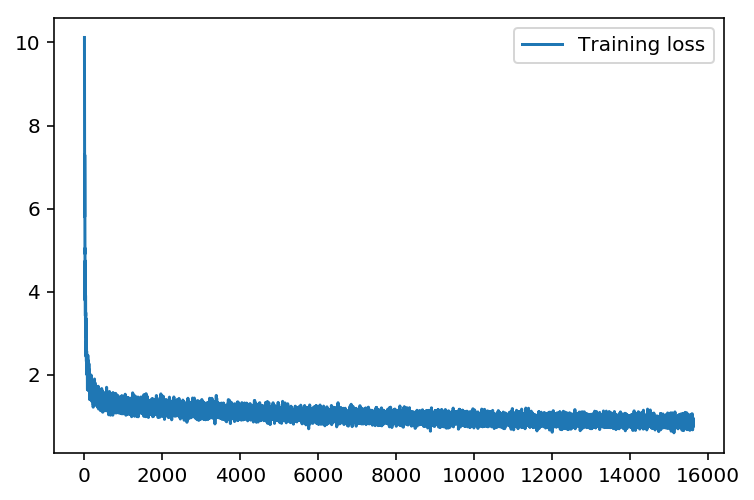

In [26]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 获取 Tensors
使用函数 get_tensor_by_name()从 loaded_graph 中获取tensors，后面的推荐功能要用到。

In [27]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") # 之前是MatMul:0 因为inference代码修改了 
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat

### 根据用户ID和电影ID，预测评分，就是网络的正向传播

In [28]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [29]:
rating_movie(234, 1401)

INFO:tensorflow:Restoring parameters from ./save


[array([[3.9628615]], dtype=float32)]

### 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存在本地

In [30]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [31]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

### 生成 User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存在本地

In [32]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [33]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

## 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

### 推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [34]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [35]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
941
[953 "It's a Wonderful Life (1946)" 'Drama']
1168
[1185 'My Left Foot (1989)' 'Drama']
3413
[3482 'Price of Glory (2000)' 'Drama']
568
[572 'Foreign Student (1994)' 'Drama']
1115
[1131 'Jean de Florette (1986)' 'Drama']


{568, 941, 1115, 1168, 3413}

### 推荐您喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [36]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results

In [37]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
3366
[3435 'Double Indemnity (1944)' 'Crime|Film-Noir']
3815
[3885 'Love & Sex (2000)' 'Comedy|Romance']
910
[922 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)' 'Film-Noir']
847
[858 'Godfather, The (1972)' 'Action|Crime|Drama']
1242
[1262 'Great Escape, The (1963)' 'Adventure|War']


{847, 910, 1242, 3366, 3815}